### Active Learning

Download the titanic dataset here: https://drive.google.com/file/d/0Bz9_0VdXvv9bbVhpOEMwUDJ2elU/view?usp=sharing

In this exercise, we will simulate active learning. We will keep the small sample of observations for testing and we will test how quality of the model rises when we use active learning to choose labeled observations.

In [17]:
import pandas as pd
import sys
sys.path.append(r"C:\Users\silvh\OneDrive\lighthouse\custom_python")
from silvhua import *
from modelling import *
from silvhua_plot import *
import matplotlib.pyplot as plt
import seaborn as sns


In [260]:
# Load the Data into variable df
df = load_csv('titanic_train.csv', r'C:\Users\silvh\OneDrive\lighthouse\W08')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### *EDA*

In [15]:
# See the number of cabin number letters
df['Cabin'].str.replace('(^[A-Z]).*','\\1', regex=True).value_counts()
# print(df['Cabin'].str.replace('(^[A-Z]).*','\\1', regex=True))


C    55
B    42
E    27
D    25
A    13
F    12
G     4
T     1
Name: Cabin, dtype: int64

In [20]:
df['Embarked'].value_counts()

S    577
C    146
Q     66
Name: Embarked, dtype: int64

In [75]:
df['Survived'].value_counts()
# 0 = No, 1 = Yes

0    429
1    262
Name: Survived, dtype: int64

C:\Users\silvh\OneDrive\lighthouse\custom_python\silvhua_plot.py:143: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.corr(), dtype=bool))
C:\Users\silvh\OneDrive\lighthouse\custom_python\silvhua_plot.py:147: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return df.corr()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.003085,-0.025753,0.028147,-0.063269,-0.003742,0.014454
Survived,-0.003085,1.000000,-0.332277,-0.067469,-0.033986,0.079474,0.249163
Pclass,-0.025753,-0.332277,1.000000,-0.366224,0.080317,0.029829,-0.547497
Age,0.028147,-0.067469,-0.366224,1.000000,-0.305136,-0.182457,0.090477
SibSp,-0.063269,-0.033986,0.080317,-0.305136,1.000000,0.417110,0.154242
Parch,-0.003742,0.079474,0.029829,-0.182457,0.417110,1.000000,0.201851
Fare,0.014454,0.249163,-0.547497,0.090477,0.154242,0.201851,1.000000


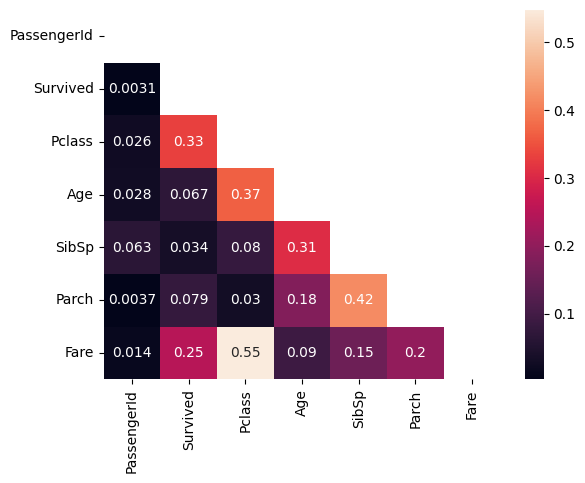

In [18]:
correlation_plot(df)
# Pclass and Fare correlate somewhat

### *Data Prep Pipeline*

In [6]:
print(df.columns)
df.dtypes

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

In [28]:
# y = df['Survived']
numeric = [
    'Age', 'SibSp',
    'Parch', 
    'Fare', 
]
categorical = [
    'Pclass',
    'Sex',
    'Embarked'
]
numeric_transform = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler()),
    ])
cat_transform = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(sparse=False))
])
preprocessing = ColumnTransformer(transformers=[
    ('num_pipeline', numeric_transform, numeric),
    ('cat_pipeline', cat_transform, categorical)
])

In [51]:
# Check that preprocessing steps work
print(type(preprocessing.fit_transform(test_df)))
preprocessing.fit_transform(test_df).shape

<class 'numpy.ndarray'>


(100, 12)

### *Obtain samples*

In [261]:
# TEST SAMPLE
# USE THIS SAMPLE ONLY FOR TESTING
test_df = df.sample(n=100, random_state=42)
# KEEP ONLY THOSE WHO ARE NOT IN THE TEST SET
df = df[~df.PassengerId.isin(test_df.PassengerId.tolist())]

In [262]:
# FIT THE FIRST MODEL ONLY ON THE DATAFRAME START_DF
start_df = df.sample(n=100, random_state=42)
# DROP OBS FROM START_DF FROM DF
df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

### Tasks

1. fit the first model only on the **start_df** using **SVM** and evaluate accuracy, precision and recall on test_df
2. in each iteration, add 10 observations from **df** to your trainset (choose the observation using active learning approach) 
    - score all observations in df and take 10 where the model isn't sure what class it is. The probability of surviving will be around 50% 
3. refit the model and evaluate on **test_df** again.    
3. the goal is to converge to the optimal solution as fast as possible by choosing **right** observations in each iteration
4. plot the graphs for each eval metric, where on the axis x is iteration number, on y is the metric value for that model

#### *Modelling*

In [77]:
# Modelling pipeline
model = SVC(probability=True)
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', model)
])
y_start = start_df.loc[:,'Survived'].to_numpy()
# type(y_start)
# type(start_df)
pipeline.fit(start_df, y_start)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('model', SVC(probability=True))])

In [78]:
pipeline.decision_function(start_df)

array([-1.03824195, -0.99982341,  1.05376818,  1.09655323,  0.4588597 ,
       -1.09279082,  0.99990731, -0.19908975, -0.99994281, -1.01484544,
        1.00000188, -1.00627849, -1.04715551,  0.99987346, -1.00045764,
       -1.03261254, -1.03261254,  1.01194434,  1.00008254, -1.02786404,
       -1.03263375,  0.99990816, -0.98599879, -0.99969646,  0.40177397,
       -1.00592742, -0.99983798,  0.03835836,  0.66057405,  0.6434799 ,
       -0.83763748, -0.99198609,  0.99992439, -1.00012649, -0.97389853,
       -1.02038755, -1.00975955,  1.00402573,  0.54521527, -1.04359314,
        0.96862193, -1.02657395, -1.00263878, -1.0511992 , -1.03263375,
       -0.99990963, -1.04893268,  0.96312083, -0.99745554, -1.01506109,
       -1.09570824, -1.01804952,  0.36620892,  1.00022968,  0.9997037 ,
       -0.97734242, -1.03212288, -1.01796418, -0.99982779, -0.53929466,
       -0.99987492, -0.99987492,  0.99972881,  1.07083602, -0.82660251,
       -1.01207327, -0.73042948, -1.00014795,  0.99972881, -1.03

#### *Iteration 1*

In [ ]:
y_test = test_df.loc[:,'Survived'].to_numpy()


SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	83.00%		76.00%		7.00%
Recall: 	77.50%		75.00%		2.50%
Precision: 	79.49%		68.18%		11.31%
F1: 		78.48%		71.43%		7.05%


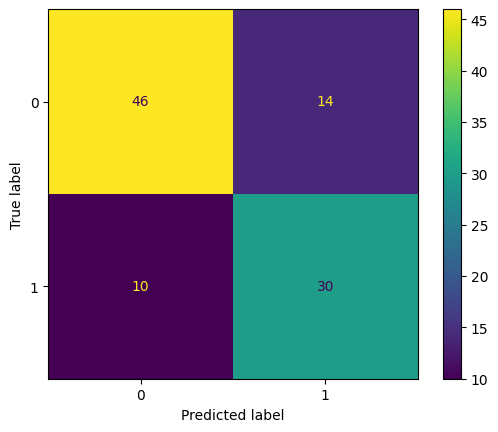

In [79]:
# Evaluate model using custom function
metrics = evaluate_classifier(model, preprocessing.fit_transform(start_df), 
    y_start, preprocessing.fit_transform(test_df), y_test, pos_label=1, model_name='SVC')

In [132]:
metrics

{'recall': (0.775,),
 'precision': 0.7948717948717948,
 'f1': 0.7848101265822786,
 'accuracy': 0.83}

#### *Iteration 2*
* SH 2022-11-13 16:04 I realize now that I did iteration 2 incorrectly by not getting class probabilities for the entire train set.

##### *Resampling*

In [90]:
pd.DataFrame(pipeline.predict_proba(start_df), columns=pipeline.classes_)

,0,1
0,0.858907,0.141093
1,0.850290,0.149710
2,0.169741,0.830259
3,0.155105,0.844895
4,0.312598,0.687402
...,...,...
95,0.265340,0.734660
96,0.851594,0.148406
97,0.210700,0.789300
98,0.861174,0.138826


In [100]:
pd.concat((start_df.reset_index(), 
    pd.DataFrame(pipeline.predict_proba(start_df), columns=pipeline.classes_)),
    axis='columns').values_sort(0)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,0,1
0,288,289,1,2,"Hosono, Mr. Masabumi",male,42.0,0,0,237798,13.0000,NaN,S,0.858907,0.141093
1,42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C,0.850290,0.149710
2,416,417,1,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34.0,1,1,28220,32.5000,NaN,S,0.169741,0.830259
3,329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C,0.155105,0.844895
4,587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.2000,B41,C,0.312598,0.687402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,0.265340,0.734660
96,173,174,0,3,"Sivola, Mr. Antti Wilhelm",male,21.0,0,0,STON/O 2. 3101280,7.9250,NaN,S,0.851594,0.148406
97,431,432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1000,NaN,S,0.210700,0.789300
98,592,593,0,3,"Elsbury, Mr. William James",male,47.0,0,0,A/5 3902,7.2500,NaN,S,0.861174,0.138826


In [113]:
# Look at the rows with the class probability closest to 0.5
    # Part 1: Append the class probability to the dataframe and calculate its distance from 0.5
pd.concat((
        start_df.reset_index(), 
        pd.DataFrame(pipeline.predict_proba(start_df)[:,pipeline.classes_[0]],columns=['class_0_proba']),
        pd.DataFrame(abs(pipeline.predict_proba(start_df)[:,pipeline.classes_[0]]-0.5),columns=['distance_from_.5'])
        ),
    axis='columns').sort_values('distance_from_.5').head(10)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,class_0_proba,distance_from_.5
24,24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.0,3,1,349909,21.0750,NaN,S,0.442971,0.057029
7,445,446,1,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S,0.560058,0.060058
76,409,410,0,3,"Lefebre, Miss. Ida",female,NaN,3,1,4133,25.4667,NaN,S,0.420225,0.079775
27,885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,0.596209,0.096209
38,436,437,0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.3750,NaN,S,0.375038,0.124962
52,295,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,27.7208,NaN,C,0.366604,0.133396
92,438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S,0.647801,0.147801
59,390,391,1,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,S,0.685403,0.185403
4,587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.2000,B41,C,0.312598,0.187402
74,97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C,0.288701,0.211299


In [119]:
    # part 2: Determine distribution of samples to add according to sex and pclass
features_for_sampling_weight = [
    'Sex',
    'Pclass'
]
pd.concat((
        start_df.reset_index(), 
        pd.DataFrame(pipeline.predict_proba(start_df)[:,pipeline.classes_[0]],columns=['class_0_proba']),
        pd.DataFrame(abs(pipeline.predict_proba(start_df)[:,pipeline.classes_[0]]-0.5),columns=['distance_from_.5'])
        ),
    axis='columns').sort_values('distance_from_.5').head(10).groupby(features_for_sampling_weight).agg(
        total=('Name','count'),
    )

,,total
Sex,Pclass,
female,3,4
male,1,6


In [168]:
feature_distribution_for_sampling = pd.concat((
        start_df.reset_index(), 
        pd.DataFrame(pipeline.predict_proba(start_df)[:,pipeline.classes_[0]],columns=['class_0_proba']),
        pd.DataFrame(abs(pipeline.predict_proba(start_df)[:,pipeline.classes_[0]]-0.5),columns=['distance_from_.5'])
        ),
    axis='columns').sort_values('distance_from_.5').head(10).groupby(features_for_sampling_weight).agg(
        total=('Name','count'),
    ).reset_index()
for row, value in feature_distribution_for_sampling['total'].items():
    print(row, value,'\n')
feature_distribution_for_sampling

0 5 

1 5 



,Sex,Pclass,total
0,female,3,5
1,male,1,5


In [151]:
# pd.concat((
#         start_df.reset_index(), 
#         pd.DataFrame(pipeline.predict_proba(start_df)[:,pipeline.classes_[0]],columns=['class_0_proba']),
#         pd.DataFrame(abs(pipeline.predict_proba(start_df)[:,pipeline.classes_[0]]-0.5),columns=['distance_from_.5'])
#         ),
#     axis='columns').sort_values('distance_from_.5').head(10).groupby(features_for_sampling_weight).agg(
#         total=('Name','count'),
#     ).index.names[0]

'Sex'

In [ ]:
# # FIT THE FIRST MODEL ONLY ON THE DATAFRAME START_DF
# start_df = df.sample(n=100, random_state=42)
# # DROP OBS FROM START_DF FROM DF
# df = df[~df.PassengerId.isin(start_df.PassengerId.tolist())]

In [122]:
sampling_filter_1 = (df['Sex'] == 'female') & (df['Pclass'] == 3)
df[sampling_filter_1].sample(n=4, random_state=42)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.00,1,5,347082,31.2750,NaN,S
47,48,1,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.7500,NaN,Q
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C


In [124]:
sampling_filter_2 = (df['Sex'] == 'male') & (df['Pclass'] == 1)
df[sampling_filter_2].sample(n=6, random_state=42)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
452,453,0,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,113051,27.7500,C111,C
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S
662,663,0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
273,274,0,1,"Natsch, Mr. Charles H",male,37.0,0,1,PC 17596,29.7000,C118,C


In [129]:
df_2 = pd.concat([
    start_df,
    df[sampling_filter_1].sample(n=4, random_state=42),
    df[sampling_filter_2].sample(n=6, random_state=42)
])
df_2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
288,289,1,2,"Hosono, Mr. Masabumi",male,42.0,0,0,237798,13.0000,NaN,S
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C
416,417,1,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34.0,1,1,28220,32.5000,NaN,S
329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C
587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.2000,B41,C
...,...,...,...,...,...,...,...,...,...,...,...,...
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S
662,663,0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


##### *Refitting model*


SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	84.55%		80.00%		4.55%
Recall: 	74.42%		72.50%		1.92%
Precision: 	84.21%		76.32%		7.89%
F1: 		79.01%		74.36%		4.65%


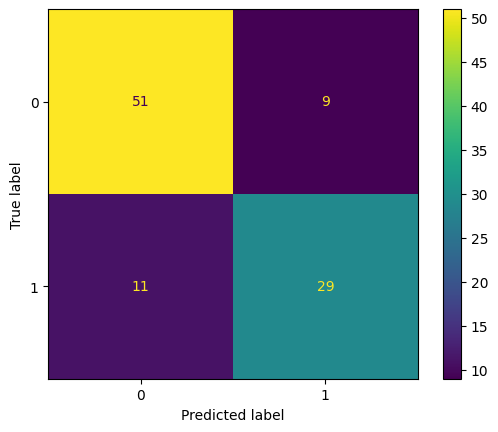

In [133]:
y_2 = df_2.loc[:,'Survived'].to_numpy()
pipeline.fit(df_2, y_2)
# Evaluate model using custom function
metrics_2 = evaluate_classifier(model, preprocessing.fit_transform(df_2), 
    y_2, preprocessing.fit_transform(test_df), y_test, pos_label=1, model_name='SVC')

# Slight improvement

In [134]:
metrics

{'recall': (0.775,),
 'precision': 0.7948717948717948,
 'f1': 0.7848101265822786,
 'accuracy': 0.83}

#### *Iterate using for loop*

In [177]:
# SH 2022-11-13 16:04 I realize now that I did iteration 2 incorrectly by not getting class probabilities for the entire train set.
# def active_learning(start_df, test_df, unsampled_df, pipeline, target_name, max_iter, model_name='SVC'):

#     accuracy = []
#     y_test = test_df.loc[:,target_name].to_numpy()
#     train_df = pd.DataFrame()
#     for iter in range(max_iter):
#         train_df = pd.concat([
#             train_df,
#             start_df
#             ])
#         y_train = train_df.loc[:,target_name].to_numpy()

#         # # Fit and evaluate the model
#         # pipeline.fit(train_df, y_train)
#         # metrics = evaluate_classifier(
#         #     model, preprocessing.fit_transform(train_df), 
#         #     y_train, preprocessing.fit_transform(test_df), 
#         #     y_test, pos_label=1, model_name=model_name
#         # )
#         # accuracy.append(metrics['accuracy'])

#         # Add new samples
#             # Create new df on
#                 # part 2: Determine distribution of samples to add according to sex and pclass
#         features_for_sampling_weight = ['Sex','Pclass']
#         feature_distribution_for_sampling = pd.concat((
#                 train_df.reset_index(), 
#                 pd.DataFrame(pipeline.predict_proba(train_df)[:,pipeline.classes_[0]],columns=['class_0_proba']),
#                 pd.DataFrame(abs(pipeline.predict_proba(train_df)[:,pipeline.classes_[0]]-0.5),columns=['distance_from_.5'])
#                 ),
#             axis='columns').sort_values('distance_from_.5').head(10).groupby(
#                 features_for_sampling_weight).agg(total=('Name','count'),
#             ).reset_index()
#         for row, value in feature_distribution_for_sampling['total'].items():
#             sampling_filter = (
#                 unsampled_df[features_for_sampling_weight[0]] == feature_distribution_for_sampling.loc[row,features_for_sampling_weight[0]]) & (
#                 unsampled_df[features_for_sampling_weight[1]] == feature_distribution_for_sampling.loc[row,features_for_sampling_weight[1]])
#             # train_df = pd.concat([
#             #     train_df,
                
#             # ])
            

#     return unsampled_df[sampling_filter]

# max_iter = 1
# active_learning(df_2, test_df, df, pipeline, 'Survived', max_iter)


In [179]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [178]:
pd.DataFrame(pipeline.predict_proba(df), columns=pipeline.classes_)

,0,1
0,0.853794,0.146206
1,0.170258,0.829742
2,0.174655,0.825345
3,0.180262,0.819738
4,0.848784,0.151216
...,...,...
686,0.176493,0.823507
687,0.843526,0.156474
688,0.180421,0.819579
689,0.370799,0.629201


In [265]:
def evaluate_classifier_2(classifier, X_test, y_test, X_train, y_train, pos_label=1,model_name='classifier', confusion_matrix=True):
    """
    Print evaluation metrics of the classifier. Classifier should be fit prior to calling this function.
        * recall
        * precision
        * F1
        * AUC score (only if class labels are integers)
    Plot:
        * confusion matrix
        * ROC (only if class labels are integers)
    Parameters:
    - pos_label (str or int): Class label for positive class. Default is 1.
    - model_name (string, optional): Name of model printing purposes.

    Returns evaluation metrics for test data set as a dictionary
    """
    
    best_model = classifier

    y_pred = best_model.predict(X_test)

    y_pred_train = best_model.predict(X_train)

    # Metrics for test data
    metrics = dict()
    if len(set(y_test)) == 2:
        recall = recall_score(y_test, y_pred, pos_label=pos_label)
        precision = precision_score(y_test, y_pred, pos_label=pos_label)
        f1score = f1_score(y_test, y_pred, pos_label=pos_label)
        metrics['recall'] = recall
        metrics['precision'] = precision
        metrics['f1'] = f1score

    accuracy = accuracy_score(y_test, y_pred)
    metrics['accuracy'] = accuracy

    # Metrics for training data
    metrics_train = dict()
    if len(set(y_test)) == 2:
        recall_train = recall_score(y_train, y_pred_train, pos_label=pos_label)
        precision_train = precision_score(y_train, y_pred_train, pos_label=pos_label)
        f1score_train = f1_score(y_train, y_pred_train, pos_label=pos_label)
        metrics_train['recall'] = recall_train
        metrics_train['precision'] = precision_train
        metrics_train['f1'] = f1score_train
    accuracy_train = accuracy_score(y_train, y_pred_train)
    metrics_train['accuracy'] = accuracy_train

    print(f'\n{model_name} evaluation metrics: \n\tTest data\tTraining data\t\tDifference')
    print(f'Accuracy: \t{100*accuracy:.2f}%\t\t{100*accuracy_train:.2f}%\t\t{100*(accuracy-accuracy_train):.2f}%')
    if len(set(y_test)) == 2:
        print(f'Recall: \t{100*recall:.2f}%\t\t{100*recall_train:.2f}%\t\t{100*(recall-recall_train):.2f}%')
        print(f'Precision: \t{100*precision:.2f}%\t\t{100*precision_train:.2f}%\t\t{100*(precision-precision_train):.2f}%')
        print(f'F1: \t\t{100*f1score:.2f}%\t\t{100*f1score_train:.2f}%\t\t{100*(f1score-f1score_train):.2f}%')
        if type(y_test) == 'int':
            auc = roc_auc_score(y_test, y_pred)
            auc_train = roc_auc_score(y_train, y_pred_train)
            print(f'AUC: \t\t{100*auc:.2f}%\t\t{100*auc_train:.2f}%\t\t{100*(auc-auc_train):.2f}%')
            RocCurveDisplay.from_estimator(best_model, X_train, y_train)
            metrics['auc'] = auc
    if confusion_matrix==True:
        ConfusionMatrixDisplay.from_estimator(best_model, X_train, y_train)
    return metrics, metrics_train


SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	83.00%		75.00%		8.00%
Recall: 	77.50%		75.00%		2.50%
Precision: 	79.49%		66.67%		12.82%
F1: 		78.48%		70.59%		7.89%

SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	85.45%		81.00%		4.45%
Recall: 	69.05%		72.50%		-3.45%
Precision: 	90.62%		78.38%		12.25%
F1: 		78.38%		75.32%		3.05%

SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	85.00%		82.00%		3.00%
Recall: 	63.64%		72.50%		-8.86%
Precision: 	93.33%		80.56%		12.78%
F1: 		75.68%		76.32%		-0.64%

SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	84.62%		82.00%		2.62%
Recall: 	72.00%		72.50%		-0.50%
Precision: 	85.71%		80.56%		5.16%
F1: 		78.26%		76.32%		1.95%

SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	80.71%		82.00%		-1.29%
Recall: 	55.56%		72.50%		-16.94%
Precision: 	90.91%		80.56%		10.35%
F1: 		68.97%		76.32%		-7.35%

SVC evaluation metrics: 
	Test data	Traini

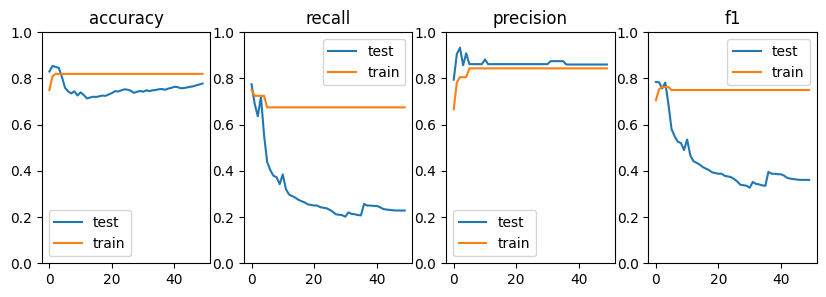

In [276]:
# SH 2022-11-13 create a function
def active_learning(start_df, test_df, unsampled_df, pipeline, target_name, max_iter, model_name='SVC'):
    
    metrics_lists = {
        'accuracy' : [],
        'recall' : [],
        'precision' : [],
        'f1' : [],
    }
    train_metrics_lists = {
        'accuracy' : [],
        'recall' : [],
        'precision' : [],
        'f1' : [],
    }
    

    y_test = test_df.loc[:,target_name].to_numpy()
    train_df = pd.DataFrame()
    train_df = pd.concat([
        train_df,
        start_df
        ])
    for iter in range(max_iter):
        y_train = train_df.loc[:,target_name].to_numpy()

        # Fit and evaluate the model
        pipeline.fit(train_df, y_train)

        # Make lists of the metrics for each iteration
        iter_metrics, train_iter_metrics = evaluate_classifier_2( # custom function
            model, preprocessing.fit_transform(train_df), 
            y_train, preprocessing.transform(test_df), 
            y_test, pos_label=1, model_name=model_name,
            confusion_matrix=False
        )
        for metric, value in iter_metrics.items():
            metrics_lists[metric].append(value)
        for metric, value in train_iter_metrics.items():
            train_metrics_lists[metric].append(value)

        # Find the 10 rows from the unsampled_df with the predict_proba values closest to 0.5
        probability = pd.concat((
            # start_df.reset_index(), 
            pd.DataFrame(pipeline.predict_proba(unsampled_df)[:,pipeline.classes_[0]],columns=['class_0_proba']),
            pd.DataFrame(abs(pipeline.predict_proba(unsampled_df)[:,pipeline.classes_[0]]-0.5),columns=['distance_from_.5'])
            ),
        axis='columns').sort_values('distance_from_.5').head(10)
        # Reset the index so it aligns with the index of the `probability` dataframe, then drop the old index
        unsampled_df = unsampled_df.reset_index().drop(columns='index')

        # Transfer 10 samples from unsampled_df to train_df for re-fitting
        train_df = pd.concat([
            train_df,
            unsampled_df[unsampled_df.index.isin(probability.index.tolist())]
        ])
        unsampled_df = unsampled_df.drop(index=probability.index)
        # print(f'Remaining unfitted samples: {unsampled_df.shape[0]}. Samples in fitting: {train_df.shape[0]}')
        if (len(df) <= 10):
            break

    # Plot the metrics
    nrows = 1
    ncols = len(metrics_lists)
    fig, ax = plt.subplots(nrows=nrows ,ncols=ncols, figsize=(10,nrows*3))
    ymin = 0
    ymax = 1
    i = 0
    for metric, value in metrics_lists.items():    
        title_variable = metric
        sns.lineplot(y=value, label='test',
            x=np.arange(0,len(value)), 
            ax = ax[i])
        sns.lineplot(y=train_metrics_lists[metric], 
            x=np.arange(0,len(value)),  label='train',
            ax = ax[i])
        ax[i].set_title(f'{title_variable}')
        ax[i].set_ylim([ymin,ymax]) # Make the y axes all the same
        i += 1
        
    return metrics_lists, train_metrics_lists

max_iter = 50
metrics_lists, train_metrics_lists = active_learning(start_df, test_df, df, pipeline, 'Survived', max_iter)


### *Repeat with SGDClassifier*

In [271]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(warm_start=True, loss='log_loss', random_state=0)

# Modelling pipeline
sgd_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('sgd_model', sgd)
])
y_start = start_df.loc[:,'Survived'].to_numpy()

sgd_pipeline.fit(start_df, y_start)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('sgd_model',
                 SGDClassifier(loss='log_loss', random_state=0,
                               warm_start=True))])


SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	79.00%		82.00%		-3.00%
Recall: 	52.50%		67.50%		-15.00%
Precision: 	91.30%		84.38%		6.93%
F1: 		66.67%		75.00%		-8.33%

SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	80.91%		82.00%		-1.09%
Recall: 	52.50%		67.50%		-15.00%
Precision: 	91.30%		84.38%		6.93%
F1: 		66.67%		75.00%		-8.33%

SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	80.00%		82.00%		-2.00%
Recall: 	48.84%		67.50%		-18.66%
Precision: 	91.30%		84.38%		6.93%
F1: 		63.64%		75.00%		-11.36%

SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	79.23%		82.00%		-2.77%
Recall: 	56.00%		67.50%		-11.50%
Precision: 	84.85%		84.38%		0.47%
F1: 		67.47%		75.00%		-7.53%

SVC evaluation metrics: 
	Test data	Training data		Difference
Accuracy: 	79.29%		82.00%		-2.71%
Recall: 	53.85%		67.50%		-13.65%
Precision: 	84.85%		84.38%		0.47%
F1: 		65.88%		75.00%		-9.12%

SVC evaluation metrics: 
	Test da

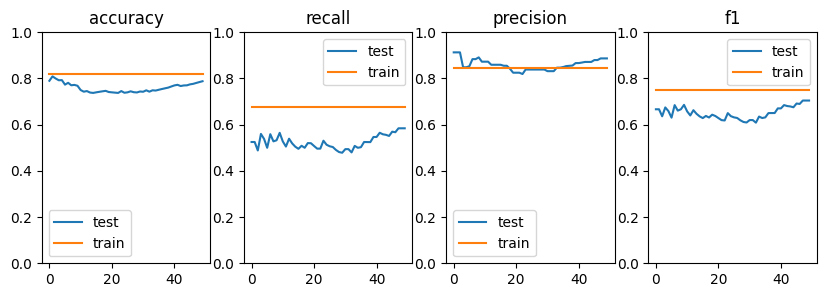

In [277]:
max_iter = 50
metrics_lists, train_metrics_lists = active_learning(start_df, test_df, df, sgd_pipeline, 'Survived', max_iter)

### *Repeat with SGDClassifier with partial fit*

In [278]:
# 2022-11-13 20:11 Update this to perform partial_fit
def active_learning_2(start_df, test_df, unsampled_df, pipeline, target_name, max_iter, model_name='SVC'):
    
    metrics_lists = {
        'accuracy' : [],
        'recall' : [],
        'precision' : [],
        'f1' : [],
    }
    train_metrics_lists = {
        'accuracy' : [],
        'recall' : [],
        'precision' : [],
        'f1' : [],
    }

    y_test = test_df.loc[:,target_name].to_numpy()
    train_df = pd.DataFrame()
    train_df = pd.concat([
        train_df,
        start_df
        ])
    for iter in range(max_iter):
        y_train = train_df.loc[:,target_name].to_numpy()

        # Fit and evaluate the model
        pipeline.partial_fit(train_df, y_train)

        # Make lists of the metrics for each iteration
        iter_metrics, train_iter_metrics = evaluate_classifier_2( # custom function
            model, preprocessing.fit_transform(train_df), 
            y_train, preprocessing.transform(test_df), 
            y_test, pos_label=1, model_name=model_name,
            confusion_matrix=False
        )
        for metric, value in iter_metrics.items():
            metrics_lists[metric].append(value)
        for metric, value in train_iter_metrics.items():
            train_metrics_lists[metric].append(value)

        # Find the 10 rows from the unsampled_df with the predict_proba values closest to 0.5
        probability = pd.concat((
            # start_df.reset_index(), 
            pd.DataFrame(pipeline.predict_proba(unsampled_df)[:,pipeline.classes_[0]],columns=['class_0_proba']),
            pd.DataFrame(abs(pipeline.predict_proba(unsampled_df)[:,pipeline.classes_[0]]-0.5),columns=['distance_from_.5'])
            ),
        axis='columns').sort_values('distance_from_.5').head(10)
        # Reset the index so it aligns with the index of the `probability` dataframe, then drop the old index
        unsampled_df = unsampled_df.reset_index().drop(columns='index')

        # Transfer 10 samples from unsampled_df to train_df for re-fitting
        train_df = pd.concat([
            train_df,
            unsampled_df[unsampled_df.index.isin(probability.index.tolist())]
        ])
        unsampled_df = unsampled_df.drop(index=probability.index)
        # print(f'Remaining unfitted samples: {unsampled_df.shape[0]}. Samples in fitting: {train_df.shape[0]}')
        if (len(df) <= 10):
            break

    # Plot the metrics
    nrows = 1
    ncols = len(metrics_lists)
    fig, ax = plt.subplots(nrows=nrows ,ncols=ncols, figsize=(10,nrows*3))
    ymin = 0
    ymax = 1
    i = 0
    for metric, value in metrics_lists.items():    
        title_variable = metric
        sns.lineplot(y=value, label='test',
            x=np.arange(0,len(value)), 
            ax = ax[i])
        sns.lineplot(y=train_metrics_lists[metric], 
            x=np.arange(0,len(value)),  label='train',
            ax = ax[i])
        ax[i].set_title(f'{title_variable}')
        ax[i].set_ylim([ymin,ymax]) # Make the y axes all the same
        i += 1
        
    return metrics_lists, train_metrics_lists
max_iter = 60
metrics_lists, train_metrics_lists = active_learning_2(start_df, test_df, df, sgd_pipeline, 'Survived', max_iter)


AttributeError: 'Pipeline' object has no attribute 'partial_fit'